# Introducción al Capstone Future spend given first trial of credit card cancelation

## Descripción del proyecto

1) El Proyecto está enfocado a temas de retención. Cuando un cliente llama al call center para cancelar su tarjeta, el ejecutivo le ofrece varias “ofertas” como la anualidad, puntos premia (que son monetizables), rewards (que se redimen en productos) o una suma de líneas, con la finalidad de que el cliente decline a su petición de “cancelar la tarjeta”.

2)	El objetivo del proyecto es estimar la facturación futura del cliente en la tarjeta que pretende cancelar, para ver si el efecto de la “oferta” sirvió para que aumente su facturación o bien, el cliente sólo encontró una oportunidad para obtener algo “extra” del banco y aun así cancelar la tarjeta. Esto es ¿vale la pena darle la “oferta" al cliente? ¿La facturación futura incremental compensa la oferta que se le hace? Y con esto determinar si se procede a la cancelación o bien se trata de retener al cliente-tarjeta

3)	El data set y proceso que dará origen, serán las bases de retención, las cuales contienen a nivel tarjeta, los intentos de cancelación y la oferta que el ejecutivo realizó al momento de la llamada.

4)	El beneficio de negocio esperado será un ahorro en las “ofertas” que se le darán al cliente. Si el cliente no se estima que tendrá un incremental de facturación, el banco se ahorrará la oferta que se le puede dar al cliente, pues no justifica la facturación el monto de la oferta, posiblemente el cliente volverá a marcar por 2da vez para concretar la cancelación

In [20]:
import pandas as pd
import numpy as np

conteo=pd.read_csv('conteo.csv', encoding='latin-1')
display(conteo)

,Mes_Fecha,Cuentas,CuentasDistintas
0,01Aug2015,"99,544","99,497"
1,01Sep2015,"191,127","190,119"
2,01Oct2015,"287,023","284,146"
3,01Nov2015,"385,602","379,863"
4,01Dec2015,"483,132","473,545"
5,01Jan2016,"574,982","560,837"
6,01Feb2016,"661,720","642,965"
7,01Mar2016,"756,744","731,995"
8,01Apr2016,"845,842","814,645"
9,01May2016,"932,000","893,763"


La base de datos es un acumulado mensual desde agosto 2015. Para fines de este hito, la exploración será basada en el mes de junio 2018, el cual cuenta con 1,291,155 registros. De este volumen, obtendremos una muestra aleatoria de 100 mil registros con la finalidad de poder trabajarlo localmente.

## Diccionario de Datos

Para fines del capstone, las variables PII de empleado se quitaron de esta muestra. Además, las variables referentes de número de cliente, cuenta y plástico han sido reemplazadas por números consecutivos.

Nuestra base de datos cuenta con las siguientes variables las cuales son:

In [166]:
train=pd.read_csv('RANDRETENCION_V2.csv', encoding='latin-1')

index_vars=train.columns

variables=pd.read_csv('variables.csv',encoding='latin-1')
vars_desc=variables[:]
vars_desc.set_index('Name', inplace=True)
i=0
for i in index_vars:
    vars_desc.loc[i,'Tipo de dato']=train[i].dtype
    
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 74)
pd.set_option('display.max_columns', 3)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

display(vars_desc)

,Descripcion,Tipo de dato
Name,,
Mes_Fecha,Fecha a la que hace referencia la información del registro,object
descontar,Campo de observaciones de la operación,object
tit_adi,Indicador que define si el intento de cancelación corresponde a una cuenta Titular o es de una tarjeta adicional,object
grupal,Grupal al que pertenece el ejecutivo,object
causa,"Descripción de razón por la que el cliente intenta cancelar, tal como fue capturada en sistema Evolución",object
subCausa,"Descripción a más detalle del por qué el cliente intentó cancelar, tal como se registró en sistema",object
cat_sucursal,Sucursal del Centro de Atención Telefónica donde se está atendiendo la llamada,object
tipo_producto,Si es uniproducto o multiproducto,object
donde_aplico,"Describe la forma en que se atendió la ejecución que se dio a la llamada:\n* Ajuste Sal, la TC fue cancelada anteriomente y ahora se solicita la eliminación de CA \n* CAT, grupal que transfirio la llamadas a Retención \n* En Linea, que el beneficio fue aplicado en línea (eCRM) \n* Papeleta, que el beneficio fue aplicado en proceso manual \n* Por Servic, no es intento de cancalación, solicitan la bonficación de comisión por rep \n* Proceso MAI, la bonficación de CA y/o ints la solicita a Mesa de atención integral (operaciones) \n",object


In [167]:
vars_desc.groupby('Tipo de dato').count()

,Descripcion
Tipo de dato,
int64,12
float64,35
object,27


De las 74 variables con las que cuenta nuestra muestra de la base de datos, 12 las identificamos como entero, 35 como punto flotante y 27 como objeto

## Análisis descriptivo

Exploraremos la muestra de nuestro dataframe con la finalidad de conocer el contenido de las variables, la dimensión de la base, cuántos nulos se tienen por fila y columna, obtendremos algunos estadísticos y distribuciones de algunas variables, con la intención de formarnos una idea lo más exacta posible de los datos que podemos considerar para los análisis correspondientes. 

Así mismo el objetivo es explorar los datos para determinar si son útiles y si es necesario estructurarlos, normalizarlos y aplicar procesos de data quality. 

### Dimensión de nuestra muestra

In [175]:
print("\n")
print("La dimensión de la muestra es:")
print("\n")
print(train.shape)



La dimensión de la muestra es:


(100000, 74)


### Muestra

A continuación haremos una exploración del contenido de la muestra de la base de datos

In [171]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_columns', 74)
pd.set_option('display.width', 1000)

train.head(10)

,Mes_Fecha,descontar,tit_adi,grupal,causa,subCausa,cat_sucursal,tipo_producto,donde_aplico,beneficio2,archivo,Info_Fecha,CAN_RET,Monto_SL,Beneficio_Otorgado,PRIM_CRD_IND,SEGMENTO_TIT,ECMTagCta,ECMTagCte,sucdepto,NOMSUBAREA,Canal,subCanal,OPEN,SALEACTIVE,ATTRITIONVOL,ATTRITIONINVOL,MONTHSONBOOKS,PURCHASE,CASHADVANCE,PAYMENT,SALES,CREDITLINE,UTILIZATIONRATE,BOOKDATE,NIM,FEEREVENUE,TNR,GCL,RECEIVABLES,ANR,PAYBALDOB,NCM,Mes_Vintage,Nivel_Rentab,Beneficio_Agrupado,Producto_Llamada,Familia_Llamada,Producto_Retencion,Familia_Retencion,Antiguedad,Elegible,ADDCARD,CANCEL_TITULAR,AGRUPA_GRUPAL,CODIGO_CAUSA,CODIGO_SUBCAUSA,Mes,FEEREVENUE_AJUST,TNR_AJUST,NCM_AJUST,Codigo_Beneficio,Codigo_Beneficio2,ARQC,PAQUETE,PAQ_NOAPLICADO,Anualidad_Doble,Sin_Corte,Autenficacion,SEGMENTO,Tasa_Preferencial,plastico,cliente,cuenta
0,01JUN2018,NaN,Titular,GENERAL,No Usa La Tarjeta Bmx,No Uso La Tarjeta Porque Me Endeudo,CAT,Multip,En Linea,NaN,Tit_can,18DEC2017,2,NaN,Cancelar,P,A,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,136.0,0.00,0.0,NaN,0.00,NaN,NaN,01MAR2007,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,6,No Definido,NaN,Affinity Card,Coemitida,Affinity Card,Coemitida,Más de 10 Años,1,NaN,NaN,General,C12,S89,NaN,0.00000,0.00000,0.00000,B66,NaN,0,0,0,0,0,0,AM,0,5,299041.0,5
1,01JUN2018,NaN,Titular,GENERAL,Comisiones Altas Banamex,Anualidad Tarjeta Titular_adicional,CAT,Multip,En Linea,NaN,Tit_ret,14FEB2018,1,NaN,Cualitativos Atributos Del Producto,P,B,5.0,5.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,136.0,358.46,0.0,2913.35,358.46,51000.0,0.16396,01MAR2007,-57.22,12.90,-44.32,0.0,8361.87,8898.22,1.0,-44.32,4,No Definido,NaN,Affinity Card,Coemitida,Affinity Card,Coemitida,Más de 10 Años,1,NaN,NaN,General,C7,S6,NaN,12.90456,-44.31992,-44.31992,B81,NaN,0,0,0,0,0,0,BM,0,29,73816.0,28
2,01JUN2018,NaN,Titular,GENERAL,No Tiene El Plastico,No Ha Recibido Su Tarjeta Y Ya Se Intento En Mas De 2 Ocasiones,CAT,Multip,En Linea,NaN,Tit_ret,10JAN2018,1,NaN,Cualitativos Atributos Del Producto,P,A,5.0,5.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,136.0,106.47,0.0,730.64,106.47,82000.0,0.00880,01MAR2007,26.85,513.83,539.62,0.0,721.20,681.18,1.0,539.62,5,No Definido,NaN,Affinity Card,Coemitida,Affinity Card,Coemitida,Más de 10 Años,1,NaN,NaN,General,C27,S248,NaN,513.83292,539.61756,539.61756,B81,NaN,0,0,0,0,0,0,AM,0,42,18042.0,40
3,01JUN2018,NaN,Titular,General,Comisiones Altas Banamex,Anualidad Tarjeta Titular_adicional,CAT,Unipro,En Linea,NaN,Tit_can,07MAY2018,2,NaN,Cancelar,P,C,3.0,3.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,135.0,0.00,0.0,NaN,0.00,NaN,NaN,01APR2007,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,1,No Definido,NaN,Affinity Card,Coemitida,Affinity Card,Coemitida,Más de 10 Años,1,NaN,NaN,General,C7,S6,NaN,0.00000,0.00000,0.00000,B66,NaN,0,0,0,0,0,0,CU,0,58,599267.0,57
4,01JUN2018,NaN,Titular,GENERAL,No Usa La Tarjeta Bmx,No Uso La Tarjeta Porque Prefiero El Efectivo_debito,CAT,Unipro,En Linea,NaN,Tit_can,29DEC2017,2,NaN,Cancelar,P,C,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,135.0,0.00,0.0,NaN,0.00,NaN,NaN,01APR2007,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,6,No Definido,NaN,Affinity Card,Coemitida,Affinity Card,Coemitida,Más de 10 Años,1,NaN,NaN,General,C12,S170,NaN,0.00000,0.00000,0.00000,B66,NaN,0,0,0,0,0,0,CU,0,63,565729.0,62
5,01JUN2018,NaN,Titular,ESPECIAL,Comisiones Altas Banamex,Anualidad Tarjeta Titular_adicional,CAT,Multip,En Linea,NaN,Tit_ret\r,05MAY2017,1,NaN,Premia_10 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes,P,NaN,4.0,4.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,135.0,0.00,0.0,1000.00,0.00,10500.0,0.96473,01APR2007,341.28,0.00,341.28,0.0,10129.67,9846.40,0.1,341.28,13,No Definido,NaN,Affinity Card,Coemitida,Affinity Card,Coemitida,Más de 10 Años,1,NaN,NaN,Especial,C7,S6,NaN,0.00000,341.27782,341.27782,B50,NaN,0,0,0,0,0,0,DM,0,76,599669.0,74
6,01JUN2018,NaN,Titular,General,Mal Servicio,Mal Servicio En General De Banamex,CAT,Unipro,En Linea,NaN,Tit_ret,05MAY2018,1,NaN,Bonificacion Ca 100 Por Ciento,P,B,5.0,5.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,135.0,298.05,0.0,630.80,298.05,63000.0,0.0566

### Validamos nulos por fila y columna

In [173]:
print("\n")
def num_nulos(x):
    return x.isnull().sum()

print("Número de Nulos por fila")
print(train.apply(num_nulos, axis=1))



Número de Nulos por fila
0        17
1        12
2        12
3        15
4        17
5        13
6        12
7        37
8        38
9        17
10       12
11       17
12       11
13       12
14       14
15       11
16       17
17       17
18       16
19       38
20       12
21       17
22       17
23       13
24       38
25       12
26       12
27       14
28       38
29       12
30       38
31       16
32       12
33       38
34       12
35       11
36       38
         ..
99963    18
99964    39
99965    18
99966    39
99967    12
99968    39
99969    39
99970    18
99971    39
99972    38
99973    18
99974    17
99975    39
99976    13
99977    14
99978    18
99979    39
99980    18
99981    13
99982    14
99983    39
99984    39
99985    14
99986    14
99987    18
99988    18
99989    39
99990    14
99991    18
99992    18
99993    39
99994    18
99995    18
99996    39
99997    39
99998    16
99999    14
Length: 100000, dtype: int64


In [177]:
print("Número de Nulos por columna")
print(train.apply(num_nulos, axis=0))

Número de Nulos por columna
Mes_Fecha             0     
descontar             98078 
tit_adi               0     
grupal                0     
causa                 3     
subCausa              3     
cat_sucursal          5     
tipo_producto         12538 
donde_aplico          3     
beneficio2            100000
archivo               0     
Info_Fecha            0     
CAN_RET               0     
Monto_SL              92939 
Beneficio_Otorgado    0     
PRIM_CRD_IND          0     
SEGMENTO_TIT          5194  
ECMTagCta             48248 
ECMTagCte             48248 
sucdepto              100000
NOMSUBAREA            100000
Canal                 100000
subCanal              100000
OPEN                  27038 
SALEACTIVE            27038 
ATTRITIONVOL          27038 
ATTRITIONINVOL        27038 
MONTHSONBOOKS         27038 
PURCHASE              27038 
CASHADVANCE           27038 
PAYMENT               60446 
SALES                 27038 
CREDITLINE            57553 
UTILIZATIONRATE

Podemos ver que de las 74 variables, hay 8 variables que no están pobladas.

## Data Profiling

Para fines de la presente entrega del Hito 3, y a sugerencia del equipo, los nombres de productos del banco, beneficios otorgados y demás serán reemplazados con valores consecutivos ordenados por volumen de llamdas o bien agrupados sin descripción a detalle de lo que contiene su valor.

### Variables numéricas

A continuación haremos un análisis univariado de nuestras variables numéricas.

In [27]:
l=[x for x in train.columns if train[x].dtype != 'object' and x not in ['cliente','plastico','cuenta']]

pd.set_option('display.max_columns', 74)

train[l].describe()

,beneficio2,CAN_RET,ECMTagCta,ECMTagCte,sucdepto,NOMSUBAREA,Canal,subCanal,OPEN,SALEACTIVE,ATTRITIONVOL,ATTRITIONINVOL,MONTHSONBOOKS,PURCHASE,CASHADVANCE,PAYMENT,SALES,CREDITLINE,UTILIZATIONRATE,NIM,FEEREVENUE,TNR,GCL,RECEIVABLES,ANR,PAYBALDOB,NCM,Mes_Vintage,Beneficio_Agrupado,Elegible,ADDCARD,CANCEL_TITULAR,Mes,FEEREVENUE_AJUST,TNR_AJUST,NCM_AJUST,Codigo_Beneficio2,ARQC,PAQUETE,PAQ_NOAPLICADO,Anualidad_Doble,Sin_Corte,Autenficacion,Tasa_Preferencial
count,0.0,100000.000000,51752.000000,51752.000000,0.0,0.0,0.0,0.0,72962.000000,72962.000000,72962.000000,72962.000000,72962.000000,72962.000000,72962.000000,39554.000000,72962.000000,42447.000000,42447.000000,72962.000000,72962.000000,72962.000000,72962.000000,7.296200e+04,7.296200e+04,72962.000000,72697.000000,100000.000000,0.0,100000.000000,15931.0,52.0,0.0,72962.000000,72962.000000,72697.000000,0.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,NaN,1.567690,3.750889,4.046472,NaN,NaN,NaN,NaN,0.581769,0.317480,0.083153,0.003742,56.161440,2293.553137,118.231511,4885.862853,2411.784648,68254.374373,0.231112,55.681966,179.086447,218.998766,25.597365,7.702260e+03,7.658758e+03,5.491687,194.106404,6.615700,NaN,0.982930,1.0,1.0,NaN,179.086506,218.998753,194.106388,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,NaN,0.495399,1.252344,1.112198,NaN,NaN,NaN,NaN,0.493272,0.465499,0.276115,0.061055,72.610024,9481.801025,1394.354768,11668.949965,9633.007973,81011.837173,0.376700,400.806533,503.849984,623.598558,1472.780540,2.301006e+04,2.233858e+04,664.322640,1605.739085,4.577364,NaN,0.129533,0.0,0.0,NaN,503.850004,623.598546,1605.739079,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,NaN,1.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,-41693.980000,-6089.320000,0.000000,-41693.980000,1.000000,0.000000,-29952.790000,-4543.680000,-29128.860000,0.000000,0.000000e+00,0.000000e+00,0.000000,-165209.510000,-1.000000,NaN,0.000000,1.0,1.0,NaN,-4543.680000,-29128.860970,-165209.510000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,NaN,1.000000,2.000000,4.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,18199.500000,0.000000,-6.290000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,3.000000,NaN,1.000000,1.0,1.0,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,NaN,2.000000,4.000000,4.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,1470.000000,0.000000,43500.000000,0.072030,0.000000,0.000000,0.000000,0.000000,0.000000e+00,5.294500e+01,0.000000,0.000000,7.000000,NaN,1.000000,1.0,1.0,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,NaN,2.000000,5.000000,5.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,67.000000,743.750000,0.000000,4985.280000,882.962500,84400.000000,0.350525,0.000000,146.390000,174.205000,0.000000,5.316263e+03,5.698025e+03,1.000000,175.980000,11.000000,NaN,1.000000,1.0,1.0,NaN,146.391930,174.201885,175.979320,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,NaN,2.000000,5.000000,5.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,591.000000,957754.220000,100000.000000,562412.890000,957754.220000,1000000.000000,42.227880,19449.310000,34479.150000,21612.780000,165209.510000,1.067931e+06,1.043363e+06,150500.000000,21612.780000,14.000000,NaN,1.000000,1.0,1.0,NaN,34479.151920,21612.782060,21612.782060,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Como variables "clave" para describir se encuentran:

***CREDITLINE:*** Podemos ver que el 25% de la población cuenta con una línea de aproximadamente 18k pesos, una mediana de 43k pesos y el percetil 75 es de 84k pesos. En promedio son 42k pesos de línea (hay más muestra en líneas bajas).

***MONTHSONBOOKS:*** Vemos que el 25% de la población tiene poco más de 1 año con su tarjeta, la mediana es de 29 meses y el percetil 75 de 67 meses. En promedio, nuestra muestra cuenta con 56 meses de antigüedad con su tarjeta de crédito.

***PURCHASE:*** Podemos ver que hasta la mediana tiene valor 0, y el percetil 75 es de 743 pesos. Esto podría dejarnos concluir que la mayoría de los registros en nuestra muestra no han usado su tarjeta al no registrar ninguna compra.

***RECEIVABLES:*** De la misma forma, así como en compras no se ve reflejado algún valor diferente de 0 para la mayoría de los registros, para el saldo de la tarjeta pasa lo mismo. Sólo el percentil 75 presenta un saldo de 5,316 pesos y en promedio son 7,700 pesos de saldo.

***NCM:*** Vemos que pasa lo mismo, ante la falta de uso de la tarjeta, sólo el último cuartil tiene un NCM (Net Credit Margin) mayor a 175 pesos, el resto de los registros no generan valor al banco.

***UTILIZATIONRATE:*** Sólo el 25% de los registros cuenta con una utilización mayor al 35% de su línea de crédito. El valor máximo es atípico y p odría tratarse de un mal cálculo o de un outlier.

### Variables categóricas

Ahora veamos algunas variables categóricas que previamente han sido reemplazados sus valores para fines de este entragable:

In [180]:
# @hidden_cell
train.replace('CAT','Teléfono', inplace=True)
train.replace('SucursalCasa','Otro', inplace=True)
train.replace('Sucursal','Otro', inplace=True)
train.replace('Oro','Otro', inplace=True)
train.replace('Welcome','Otro', inplace=True)
display(train['cat_sucursal'].value_counts(normalize=True).to_frame())

,cat_sucursal
Teléfono,0.99252
Otro,0.00748


Podemos ver que el 99% de las observaciones de nuestra muestra entran por el teléfono, y menos del 1% por otro canal

In [135]:
# @hidden_cell
pd.set_option('display.max_rows', 140)
pd.set_option('display.width', 1000)
train.replace('Tiene Varias Tarjetas','Varias TC', inplace=True)
train.replace('No Usa La Tarjeta Bmx','Sin uso', inplace=True)
train.replace('Asesoria Incorrecta Del Vendedor De','Venta', inplace=True)
train.replace('Comisiones Altas Banamex','Precio', inplace=True)
train.replace('Problemas Personales','Problemas Personales', inplace=True)
train.replace('Cancelacion Adicionales','Otro', inplace=True)
train.replace('Mal Servicio','Servicio', inplace=True)
train.replace('No Tiene El Plastico','Servicio', inplace=True)
train.replace('Paquete Banamex','Servicio', inplace=True)
train.replace('Altas Tasas Banamex','Precio', inplace=True)
train.replace('Producto','Servicio', inplace=True)
train.replace('Aclaraciones','Servicio', inplace=True)
train.replace('Competencia','Precio', inplace=True)
train.replace('Cancelacin Directa','Otro', inplace=True)
train.replace('Mala Venta','Venta', inplace=True)
train.replace('Cancelacion Directa','Otro', inplace=True)
train.replace('Canales Banamex','Otro', inplace=True)
train.replace('Error En Cuenta','Otro', inplace=True)
train.replace('Retencion','Retención', inplace=True)
train.replace('Cambio Ecs','Otro', inplace=True)
display(train['causa'].value_counts(normalize=True).to_frame())

,causa
Varias TC,0.217827
Sin uso,0.195246
Precio,0.144964
Servicio,0.134214
Venta,0.131764
Problemas Personales,0.102413
Otro,0.072092
Retención,0.001480


El 21% de las llamadas de intento de cancelación se debe a que el cliente cuenta con varias tarjetas de crédito y un 20% no usa su tarjeta

In [136]:
pd.set_option('display.max_rows', 140)
train.replace('Cancelar','Cancelación', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento','Anualidad', inplace=True)
train.replace('Suma De Lineas','Suma de Líneas', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia','Rewards', inplace=True)
train.replace('Bonificacion Ca Mas Intereses Solo Por Supervisor (Ecrm: Bonificacion Ca Mas Int (Solo Supervisor)','Anualidad', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento $15','Anualidad', inplace=True)
train.replace('Cualitativos Atributos Del Producto','Otros', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento Condicionado $15','Anualidad', inplace=True)
train.replace('Bonificacion Comision Pago Tardio O Falta De Pago Y/O Mas Intereses (Ecrm: Bonificacion Ca Mas Int (','Comisión', inplace=True)
train.replace('Premia 12 Mil Puntos Y 30 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Premia 10 Mil Puntos Y 30 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $25','Rewards', inplace=True)
train.replace('Bonificacion Comisin Anual 100 Por Ciento','Anualidad', inplace=True)
train.replace('Bonificacion Ca Mas Intereses Solo Por Supervisor (Ecrm: Bonificacion Ca Mas Int (Solo Supervisor) $','Anualidad', inplace=True)
train.replace('Premia 16 Mil Puntos Y 30 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Premia 6 Mil Puntos Y 30 Por Ciento Condicionado A Facturar 6 Meses Siguientes Solo Uniproducto','Rewards', inplace=True)
train.replace('Canje De Producto','Canje', inplace=True)
train.replace('Premia 5 Mil Puntos Y 30 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Thankyou Points 17100 Puntos (Equivale Al 100 Por Ciento Ca)','Rewards', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto','Otros', inplace=True)
train.replace('Ca Programada','Anualidad', inplace=True)
train.replace('Thankyou Points 7700 Puntos (Equivale Al 100 Por Ciento Ca)','Rewards', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $90','Anualidad', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento (Mala Venta / Asesoria Incorrecta)','Anualidad', inplace=True)
train.replace('500 Puntos Haz Mas','Rewards', inplace=True)
train.replace('Premia_10 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Premia_12 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Ca Programada $15','Anualidad', inplace=True)
train.replace('Tasa Maxima 30 Por Ciento','Tasa', inplace=True)
train.replace('Premia_5 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Tasa Promocional 0 A 6 Meses','Tasa', inplace=True)
train.replace('Premia_6 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes Solo Uniproducto','Rewards', inplace=True)
train.replace('Premia_5 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $40','Rewards', inplace=True)
train.replace('Thankyou Points 3800 Puntos (Equivale Al 50 Por Ciento Ca)','Rewards', inplace=True)
train.replace('Bonif Ca, Ints Y Acc $50','Anualidad', inplace=True)
train.replace('Premia_16 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Bonificacion Comision Pago Tardio O Falta De Pago Y/O Mas Intereses (Ecrm: Bonificacin Ca Ms Int (Sl','Comisión', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $45','Rewards', inplace=True)
train.replace('Thankyou Points_17,100 Puntos (Equivale Al 100 C.A)','Rewards', inplace=True)
train.replace('Bonificacion Ca 50 Por Ciento','Anualidad', inplace=True)
train.replace('Thankyou Points_7,700 Puntos (Equivale Al 100 C.A)','Rewards', inplace=True)
train.replace('10mil Thank You Points Y 10mil Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento $20','Anualidad', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $40','Rewards', inplace=True)
train.replace('500 Puntos Haz Ms','Rewards', inplace=True)
train.replace('5mil Thank You Points Y 100 Por Ciento Condicionado A Facturar 6 Meses Siguiente','Rewards', inplace=True)
train.replace('Tasa Promocional 0 A 3 Meses','Tasa', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $110','Otros', inplace=True)
train.replace('3,500 Thank You Points $40','Rewards', inplace=True)
train.replace('Thankyou Rewards 43200 Puntos (Equivale Al 100 Por Ciento Ca)','Rewards', inplace=True)
train.replace('Thankyou_ Rewards_ 17,000 Puntos (Equivale Al 90 C.A)','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento $0','Anualidad', inplace=True)
train.replace('Diferir Ca 3 Meses','Meses', inplace=True)
train.replace('Bonificacion Ca Mas Intereses Solo Por Supervisor (Ecrm: Bonificacion Ca Mas Int (Solo Supervisor)$3','Anualidad', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $120','Otros', inplace=True)
train.replace('Premia_6 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes Solo Uniproducto $75','Rewards', inplace=True)
train.replace('Best Buy Cupon 600 Pesos','Rewards', inplace=True)
train.replace('2,500 Thank You Points $35','Rewards', inplace=True)
train.replace('2500 Thank You Points Y 100 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Thankyou_ Rewards_ 43,200 Puntos (Equivale Al 100 C.A)','Rewards', inplace=True)
train.replace('Premia_12 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $140','Rewards', inplace=True)
train.replace('Premia_10 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $35','Rewards', inplace=True)
train.replace('3 Mil Thank You Points Y 100 Por Ciento Condicionado A Facturar 6 Meses Siguiente','Rewards', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $30','Otros', inplace=True)
train.replace('Premia_6 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes Solo Uniproducto $60','Rewards', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $80','Otros', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $35','Rewards', inplace=True)
train.replace('Diferir Ca 6 Meses','Meses', inplace=True)
train.replace('300 Puntos Marti','Rewards', inplace=True)
train.replace('Thankyou Points 8500 Puntos (Equivale Al 50 Por Ciento Ca)','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento $30','Anualidad', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $90','Rewards', inplace=True)
train.replace('Thankyou_ Rewards_ 17,000 Puntos','Rewards', inplace=True)
train.replace('Tasa Maxima 19 Por Ciento','Tasa', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $0','Otros', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $55','Rewards', inplace=True)
train.replace('Premia_16 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $140','Rewards', inplace=True)
train.replace('Premia_10 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $100','Rewards', inplace=True)
train.replace('Thankyou Points_3,800 Puntos (Equivale Al 50 C.A)','Rewards', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $35','Otros', inplace=True)
train.replace('Thankyou Points_7,700 Puntos (Equivale Al 100 C.A) $90','Rewards', inplace=True)
train.replace('Premia_12 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $110','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento $25','Anualidad', inplace=True)
train.replace('Bonificacion Comisin Anual 50 Por Ciento','Anualidad', inplace=True)
train.replace('Premia_10 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $50','Rewards', inplace=True)
train.replace('Thankyou_ Rewards_ 22,500 Puntos (Vuelo Nacional Redondo)','Rewards', inplace=True)
train.replace('3,500 Thank You Points','Rewards', inplace=True)
train.replace('2,500 Thank You Points Y 100 Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Aadvantage 5 Mil Millas Y 50 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Pass Points 3500 Puntos Y 100 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('650 Puntos Marti','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento $45','Anualidad', inplace=True)
train.replace('Premia_10 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes $55','Rewards', inplace=True)
train.replace('Premia_6 Mil Puntos Y 30 Condicionado A Facturar 6 Meses Siguientes Solo Uniproducto $50','Rewards', inplace=True)
train.replace('Thankyou Points_17,100 Puntos (Equivale Al 100 C.A) $80','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $80','Rewards', inplace=True)
train.replace('Ca Programada $35','Anualidad', inplace=True)
train.replace('10mil Thank You Points Y 10mil Condicionado A Facturar 6 Meses Siguientes $140','Rewards', inplace=True)
train.replace('Tasa Promocional 0 A 6 Meses $140','Tasa', inplace=True)
train.replace('Pass Points_3,500 Puntos Y 100 Condicionado A Facturar 6 Meses Siguientes $75','Rewards', inplace=True)
train.replace('15 Mil Thank You Points Y 15 Mil Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Tasa Maxima 30 Por Ciento $30','Tasa', inplace=True)
train.replace('8mil Thank You Points Y 100 Condicionado A Facturar 6 Meses Siguiente','Rewards', inplace=True)
train.replace('Tasa Promocional 0 A 6 Meses $100','Tasa', inplace=True)
train.replace('Tasa Promocional 0 A 3 Meses $65','Tasa', inplace=True)
train.replace('Thankyou Points_3,800 Puntos (Equivale Al 50 C.A) $25','Rewards', inplace=True)
train.replace('Thankyou_ Rewards_ 8,500 Puntos (Equivale Al 45 C.A)','Rewards', inplace=True)
train.replace('Thankyou Points_7,700 Puntos (Equivale Al 100 C.A) $80','Rewards', inplace=True)
train.replace('500 Puntos Haz Ms $40','Rewards', inplace=True)
train.replace('Thankyou Points_8,500 Puntos (Equivale Al 50 C.A)','Rewards', inplace=True)
train.replace('Thankyou_ Rewards_ 21,600 Puntos (Equivale Al 50 C.A)','Rewards', inplace=True)
train.replace('Cualitativos_ Atributos Del Producto $75','Otros', inplace=True)
train.replace('Thankyou Points_7,700 Puntos (Equivale Al 100 C.A) $40','Rewards', inplace=True)
train.replace('650 Puntos Deporteismo $80','Rewards', inplace=True)
train.replace('Bonificacion Ca Mas Intereses Solo Por Supervisor (Ecrm: Bonificacion Ca Mas Int (Solo Supervisor)$0','Anualidad', inplace=True)
train.replace('Diferir Ca 3 Meses $110','Meses', inplace=True)
train.replace('Aadvantage 12 Mil 500 Millas Y 100 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('5mil Thank You Points Y 100 Condicionado A Facturar 6 Meses Siguiente','Rewards', inplace=True)
train.replace('Thankyou Rewards 117600 Puntos (Equivale Al 100 Por Ciento Ca)','Rewards', inplace=True)
train.replace('Aadvantage 7 Mil 500 Millas Y 100 Por Ciento Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('650 Puntos Deporteismo','Rewards', inplace=True)
train.replace('Aadvantage_12 Mil 500 Millas Y 100 Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Thankyou Points_17,100 Puntos (Equivale Al 100 C.A) $45','Rewards', inplace=True)
train.replace('2,500 Thank You Points Y 100 Condicionado A Facturar 6 Meses Siguientes $55','Rewards', inplace=True)
train.replace('Thankyou Points_7,700 Puntos (Equivale Al 100 C.A) $45','Rewards', inplace=True)
train.replace('Canje De Producto Informativo Para El Ejecutivo','Canje', inplace=True)
train.replace('Bonificacion Ca 50 Por Ciento $30','Anualidad', inplace=True)
train.replace('Thankyou Points_17,100 Puntos (Equivale Al 100 C.A) $35','Rewards', inplace=True)
train.replace('2,500 Thank You Points','Rewards', inplace=True)
train.replace('Pass Points_3,500 Puntos Y 100 Condicionado A Facturar 6 Meses Siguientes','Rewards', inplace=True)
train.replace('Bonificacion Ca 100 Por Ciento En Puntos Premia $100','Rewards', inplace=True)

display(train['Beneficio_Otorgado'].value_counts(normalize=True).to_frame())

,Beneficio_Otorgado
Cancelación,0.56769
Anualidad,0.19031
Rewards,0.12140
Suma de Líneas,0.06505
Otros,0.03425
Comisión,0.01491
Canje,0.00480
Tasa,0.00142
Meses,0.00017


Aproximadamente el 57% de las llamdas terminan con una cancelación. Este nivel se encuentra dentro de la columna de "Benefico", veamos si tiene coherencia con la variable de Cancelación/Retención.

In [138]:
# @hidden_cell
train.replace('Oro',1, inplace=True)
train.replace('Clasica',2, inplace=True)
train.replace('Platinum',3, inplace=True)
train.replace('Travel Pass',4, inplace=True)
train.replace('BSmart',5, inplace=True)
train.replace('CostCo',6, inplace=True)
train.replace('Home Depot',7, inplace=True)
train.replace('Affinity Card',8, inplace=True)
train.replace('Teleton',9, inplace=True)
train.replace('Soriana',10, inplace=True)
train.replace('Best Buy',11, inplace=True)
train.replace('Office Depot',12, inplace=True)
train.replace('Deporteismo',13, inplace=True)
train.replace('DSuper',14, inplace=True)
train.replace('Soccer',15, inplace=True)
train.replace('Citi Prestige',16, inplace=True)
train.replace('AAdvantage',17, inplace=True)
train.replace('Beyond',18, inplace=True)
train.replace('Socio Fundador',19, inplace=True)

display(train['Producto_Retencion'].value_counts(normalize=True).to_frame())

,Producto_Retencion
1,0.23225
2,0.17204
3,0.11469
4,0.10233
5,0.09582
6,0.07706
7,0.07366
8,0.03442
9,0.03165
10,0.01535


Podemos ver que hay un producto de tarjetas que lidera las llamadas de intento de cancelación con un 23%

In [140]:
train.replace('TITULAR','Titular', inplace=True)
train.replace('ADICIONAL','Adicional', inplace=True)
display(train['tit_adi'].value_counts(normalize=True).to_frame())

,tit_adi
Titular,0.94592
Adicional,0.05408


El 94% de las llamadas de intento de cancelación las hacemos para tarjetas titulares, mientras que poco más del 5% es para las tarjetas adicionales.

In [141]:
display(train['CAN_RET'].value_counts(normalize=True).to_frame())

,CAN_RET
2,0.56769
1,0.43231


De acuerdo al diccionario de Datos, el 2 se refiere a las cancelaciones y el 1 a la retención. El número de cancelaciones corresponde exactamente al valor que encontramos en Beneficio_Otorgado='Cancelación', por lo tanto validamos que esa información es correcta.

### Tablas cruzadas

Ahora, veamos la relación que existe entre las causas de cancelación y los beneficios otrogados mediante una tabla cruzada.

In [142]:
display(pd.crosstab([train.causa],train.Beneficio_Otorgado,margins=True, normalize=True))

Beneficio_Otorgado,Anualidad,Cancelación,Canje,Comisión,Meses,Otros,Rewards,Suma de Líneas,Tasa,All
causa,,,,,,,,,,
Otro,0.001350,0.063312,0.00061,0.00010,0.00000,0.002000,0.004220,0.000480,0.00002,0.072092
Precio,0.034921,0.060592,0.00125,0.00471,0.00005,0.005210,0.030931,0.006860,0.00044,0.144964
Problemas Personales,0.013710,0.074382,0.00018,0.00084,0.00000,0.002480,0.008030,0.002680,0.00011,0.102413
Retención,0.000050,0.001090,0.00000,0.00000,0.00000,0.000140,0.000110,0.000090,0.00000,0.001480
Servicio,0.018061,0.070262,0.00123,0.00296,0.00001,0.007960,0.027171,0.006390,0.00017,0.134214
Sin uso,0.023741,0.143034,0.00047,0.00201,0.00001,0.006100,0.012410,0.007210,0.00026,0.195246
Varias TC,0.020541,0.111433,0.00100,0.00083,0.00004,0.009770,0.032801,0.041001,0.00041,0.217827
Venta,0.077942,0.043601,0.00006,0.00346,0.00006,0.000590,0.005730,0.000310,0.00001,0.131764
All,0.190316,0.567707,0.00480,0.01491,0.00017,0.034251,0.121404,0.065022,0.00142,1.000000


Podemos ver que de los beneficios otorgados, el de cancelación (que habíamos visto que acumula el 56% de los registros de la muestra), el mayor porcentaje de causa se refiere a que el cliente no usa su tarjeta y por lo tanto decide cancelarla, y en segundo lugar es por tener varias tarjetas. De este rubro de varias tarjetas, al 4% de los registros se les hace una suma de líneas.

Ahora veamos la relación que existe entre el tipo de producto y la cantida de retenidos o cancelados.

In [143]:
display(pd.crosstab([train.CAN_RET],train.Producto_Retencion,margins=True, normalize=True))

Producto_Retencion,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,All
CAN_RET,,,,,,,,,,,,,,,,,,,,
1,0.11268,0.07280,0.06394,0.05089,0.03945,0.02301,0.02328,0.01372,0.01090,0.00463,0.00356,0.00314,0.00381,0.00170,0.00182,0.00134,0.00148,0.00015,0.00001,0.43231
2,0.11957,0.09924,0.05075,0.05144,0.05637,0.05405,0.05038,0.02070,0.02075,0.01072,0.00968,0.00794,0.00719,0.00308,0.00211,0.00193,0.00165,0.00013,0.00001,0.56769
All,0.23225,0.17204,0.11469,0.10233,0.09582,0.07706,0.07366,0.03442,0.03165,0.01535,0.01324,0.01108,0.01100,0.00478,0.00393,0.00327,0.00313,0.00028,0.00002,1.00000


Podemos ver que la cantidad de cancelaciones (valor 2), se da en su mayoría en el producto 1, aunque en casi la misma proporción se da una retención.

Veamos cuál de los beneficios agrupó mayor cantidad de retenciones.

In [145]:
display(pd.crosstab([train.CAN_RET],train.Beneficio_Otorgado,margins=True, normalize='index'))

Beneficio_Otorgado,Anualidad,Cancelación,Canje,Comisión,Meses,Otros,Rewards,Suma de Líneas,Tasa
CAN_RET,,,,,,,,,
1,0.440217,0.00000,0.011103,0.034489,0.000393,0.079226,0.280817,0.150471,0.003285
2,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
All,0.190310,0.56769,0.004800,0.014910,0.000170,0.034250,0.121400,0.065050,0.001420


Podemos ver que, vista renglón, el 44% de las retenciones se da por bonificación de algún tipo sobre la anualildad de la tarjeta, y en un 28% por otorgamiento de algún tipo de rewards.

### Gráficas de Box-Plot

Veamos ahora cómo se relacionan estas variables con algunas categóricas.

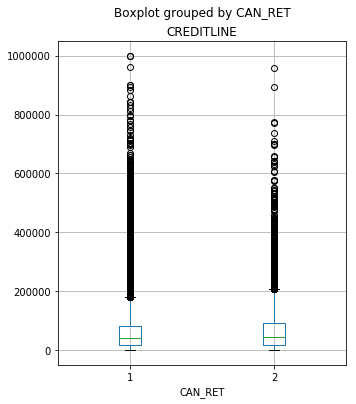

In [162]:
train.boxplot(['CREDITLINE'],by='CAN_RET',figsize=(5,6))

Podemos ver que la distribución de los percentiles 25, 50 y 75 son ligeramente menores en el valor de CAN_RET=1 (que según el diccionario de datos se refiere a los retenidos, y 2 a los cancelados). Sin embargo, hay más registros en la muestra potenciales a ser outliers con líneas más altas en la parte de retención que en la de cancelación.

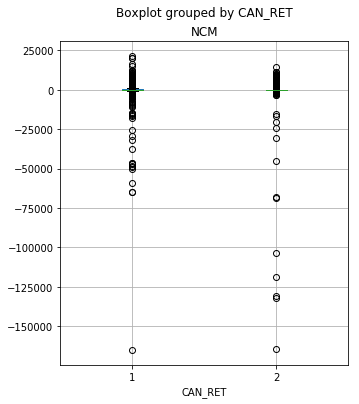

In [163]:
train.boxplot(['NCM'],by='CAN_RET',figsize=(5,6))

Podemos ver que el NCM de las cuentas en retención tiene mayor concentración cercana al 0 y en la parte positiva, mientras que los cancelados se encuentran muchos con NCM negativo muy grande. Este valor puede estar sesgado a que es un valor puntual a cierto mes y no un valor más estable como un promedio de varios meses, mediana, etc.

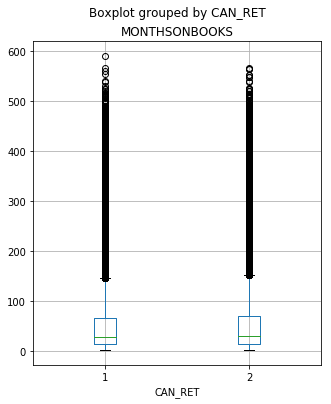

In [164]:
train.boxplot(['MONTHSONBOOKS'],by='CAN_RET',figsize=(5,6))

La antigüedad en meses de los retenidos y cancelados prácticamente es la misma en nuestra muestra.

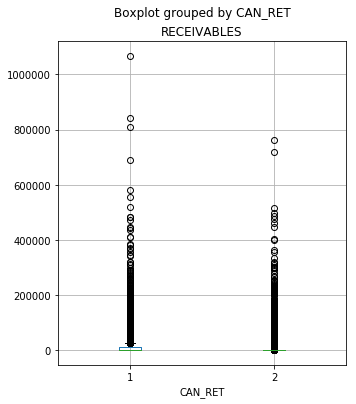

In [165]:
train.boxplot(['RECEIVABLES'],by='CAN_RET',figsize=(5,6))

Podemos ver que ligeramente hay más registros potenciales a ser outliers en saldo en los retenidos que en los cancelados.

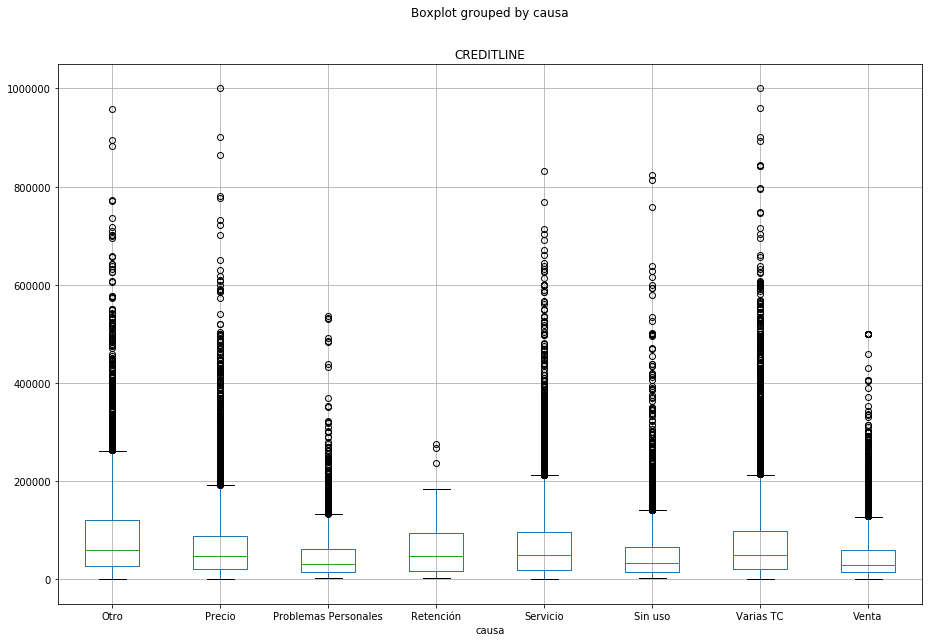

In [158]:
train.boxplot(['CREDITLINE'],by='causa',figsize=(15,10))

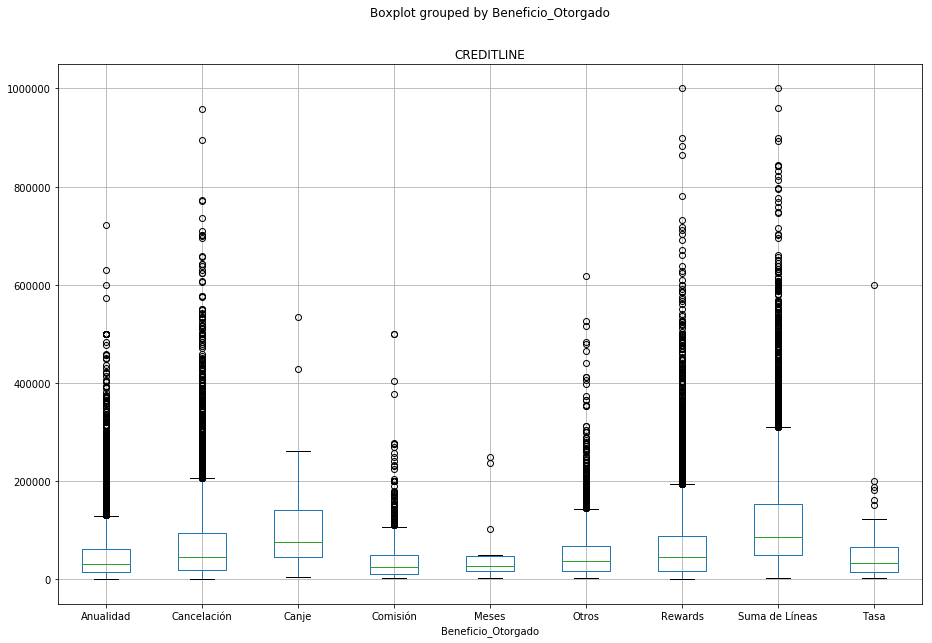

In [160]:
train.boxplot(['CREDITLINE'],by='Beneficio_Otorgado',figsize=(15,10))

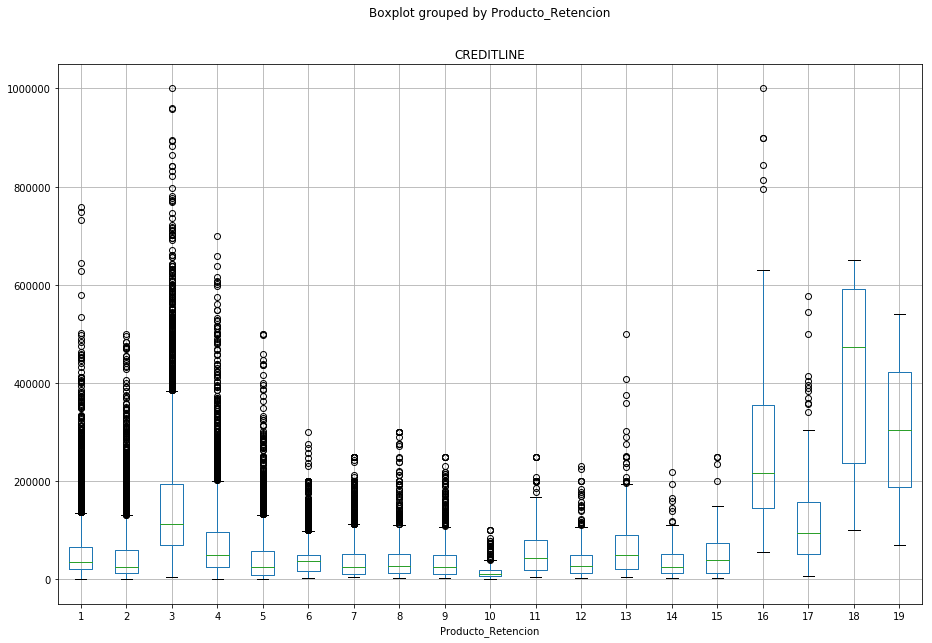

In [161]:
train.boxplot(['CREDITLINE'],by='Producto_Retencion',figsize=(15,10))

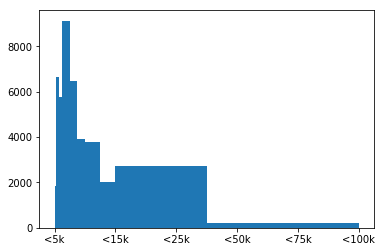

In [104]:
import matplotlib.pyplot as plt
bins = [0, 5000,15000,25000,50000,75000,100000,150000,200000,500000,1000000]  
#plt.hist(train.CREDITLINE, range=(0, 1000000),bins=bins,log=0)
fig, ax = plt.subplots()
ax.hist(train.CREDITLINE, bins=bins, range=(0,1000000),cumulative=0)
ax.set_xticklabels(('0-15k','<5k', '<15k', '<25k', '<50k', '<75k', '<100k', '<150k', '<200k','<500k','<1MM'))
plt.show()

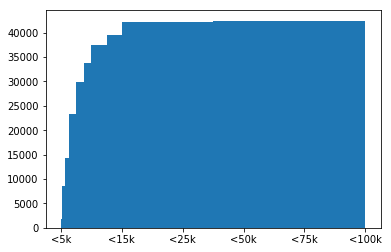

In [103]:
import matplotlib.pyplot as plt
bins = [0, 5000,15000,25000,50000,75000,100000,150000,200000,500000,1000000]  
#plt.hist(train.CREDITLINE, range=(0, 1000000),bins=bins,log=0)
fig, ax = plt.subplots()
ax.hist(train.CREDITLINE, bins=bins, range=(0,1000000),cumulative=1)
ax.set_xticklabels(('0-15k','<5k', '<15k', '<25k', '<50k', '<75k', '<100k', '<150k', '<200k','<500k','<1MM'))
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000019DDA7F0>,
      dtype=object)

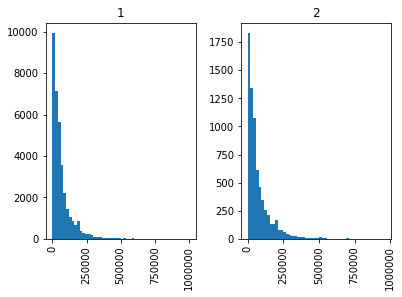

In [102]:
train.hist(column='CREDITLINE', by='CAN_RET', xlabelsize =None,bins=50)

In [ ]:
Familia_Retencion
Producto_Retencion
tit_adi
CAN_RET

## Preguntas exploratorias (research questions)

***Una vez descritos los datos mediante histogramas, conteos y series de tiempo, y perfilados con summary, y hecho el sanity check VS la realidad, entonces podemos proceder a hacerle preguntas interesantes a nuestro dataset.

***No hay límite a las preguntas que se le pueden hacer o que deben presentar, pero deben estar conectadas en una línea de investigación coherente. Por ejemplo, si deseamos predecir ingreso para validar declarado VS real, entonces haremos preguntas sobre los demográficos de los clientes de Citi, y posteriormente analizaríamos patrones de consumo para relacionar demográficos con estos patrones, y quizá sigamos con la pregunta de cuantos segmentos hay.


***¿Qué pasa con las preguntas que no llegaron a nada?

***Inclúyanlas al final del documento como anexo. Que quede evidencia de las líneas que no fueron fructíferas.


***“In science, negative findings are also findings.” -Firn et al (2006)


***Nota sobre “el síndrome del impostor”

***Cuando trabajamos un dataset de un negocio con el cual estamos familiarizdos, ocasionalmente obviamos preguntas por considerarlas muy tontas. El trabajo del científico de datos tiene más parte de detective que de programación, y esto significa que no hay pregunta tonta, ni obvia, y que incluso una pregunta obvia en el contexto de Citi como “¿cuántos clientes de nómina tenemos?” debe ser establecida y se le debe dar respuesta. Si la respuesta confirma la intuición, entonces se validará la cultura de datos de Citi, dado que es una pieza de info que todos traen en la cabeza. Si no, entonces hay desconexión entre los datos y la intuición que se tiene del negocio, y alguno de los 2 está incorrecto, lo que decantará en ajustes en cualquiera de ambos, y que, a la postre, resultará en un mismo idioma entre el científico de datos y su cliente.


***“No hay preguntas tontas, solo tontos que no son inquisitivos.” -Shaw


## Hipótesis y pruebas

***Esta sección implica formular y probar, a diferentes niveles de sofisticación y rigor, la hipótesis que será el objeto de nuestra predicción. Básicamente, significa que seleccionamos una variable objetivo, seleccionamos predictores, y probamos que la relación, influencia o información de éstas sobre la variable objetivo existe, es válida y significativa.

***Se pueden utilizar múltiples técnicas estadísticas para lograr tener la hipótesis y realizar las pruebas, desde pruebas estadísticas tradicionales (aquellas con las que pueden torturar los p-values hasta que confiesen), hasta modelos de bosques aleatorios donde se presenta el variable importance, pasando por GLMs reportando errores, confianzas y residuales.
